In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import smopy
sns.set()

from copy import copy

%matplotlib notebook 

### Find top cities

In [10]:
cities = pd.read_csv("cities.csv")
cities["Население"] = pd.to_numeric(cities["Население"])
cities = cities.sort_values("Население", ascending=False)

top_cities = cities.iloc[:30]
top_cities = top_cities[["Долгота", "Широта", "Город", "Население"]]
top_cities.reset_index(inplace=True)
top_cities.at[0, "Город"] = "Москва"
top_cities.at[1, "Город"] = "Санкт-Петербург"

In [11]:
top_cities = cities.iloc[:30]
top_cities = top_cities[["Долгота", "Широта", "Город", "Население"]]
top_cities.reset_index(inplace=True)
top_cities.at[0, "Город"] = "Москва"
top_cities.at[1, "Город"] = "Санкт-Петербург"

### Distance function

In [12]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    
    return km

### Simulated Annealing

In [13]:
def initial_path():
    return np.random.permutation([i for i in range(30)])
def tot_distance(path):
    res = 0.0
    for i in range(0, 29):
        from_ind = path[i]
        to_ind = path[i + 1]
        
        res += haversine(top_cities.iloc[from_ind]["Долгота"], top_cities.iloc[from_ind]["Широта"], top_cities.iloc[to_ind]["Долгота"], top_cities.iloc[to_ind]["Широта"])
        
    return res
def apply_policy(path):
    indices = np.random.choice(range(30), size=2, replace=False)
    
    n_path = copy(path)
    n_path[indices[0]] = path[indices[1]]
    n_path[indices[1]] = path[indices[0]]
    
    return n_path
def energy_distr(path, temperature):
    return np.exp(-tot_distance(path) / temperature)
def experiment(decay, init_temperature):
    np.random.seed(0)
    
    timestep = 0
    temperature = init_temperature

    cur_path = initial_path()
    distances = []
    paths = []
    temperatures = []
    while temperature > 1.0:
        proposal_path = apply_policy(cur_path)
        acceptance_ratio = energy_distr(proposal_path, temperature) / energy_distr(cur_path, temperature)
        if np.random.sample() <= acceptance_ratio:
            cur_path = proposal_path

        temperature = temperature * decay
        timestep += 1

        if timestep % 10 == 0:
            print("---")
            print("Iteration {}".format(timestep))
            print("Temperature: {}".format(temperature))
            print("Total distance: {}".format(tot_distance(cur_path)))
            print()

            distances.append(tot_distance(cur_path))
            paths.append(cur_path)
            temperatures.append(temperature)
            
    return distances, paths, temperatures

### Experiments

#### Small annealing

In [ ]:
distances_small1, paths_small1, temps_small1 = experiment(0.995, init_temperature=25000)

In [ ]:
distances_small2, paths_small2, temps_small2 = experiment(0.9925, init_temperature=25000)

In [ ]:
distances_small, paths_small, temps_small = experiment(0.99, init_temperature=25000)

#### Medium annealing

In [ ]:
distances_medium, paths_medium, temps_medium = experiment(0.98, init_temperature=25000)

#### Big annealing

In [ ]:
distances_big, paths_big, temps_big = experiment(0.97, init_temperature=25000)

#### Plots

<IPython.core.display.Javascript object>


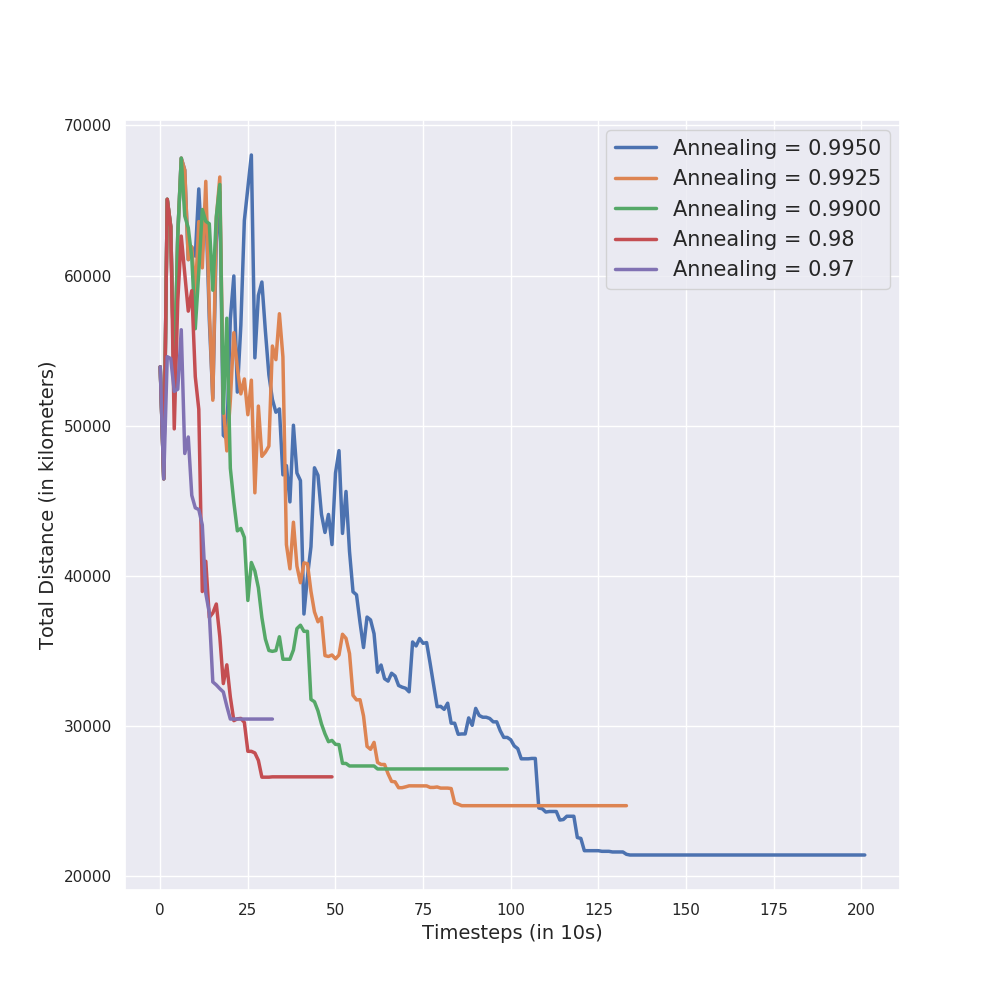

In [48]:
plt.figure(figsize=(10,10))
plt.xlabel("Timesteps (in 10s)", fontsize=14)
plt.ylabel("Total Distance (in kilometers)", fontsize=14)
plt.plot(distances_small1, label="Annealing = 0.9950", linewidth=2.5)
plt.plot(distances_small2, label="Annealing = 0.9925", linewidth=2.5)
plt.plot(distances_small, label="Annealing = 0.9900", linewidth=2.5)
plt.plot(distances_medium, label="Annealing = 0.98", linewidth=2.5)
plt.plot(distances_big, label="Annealing = 0.97", linewidth=2.5)
plt.legend(prop = {"size": 15})
plt.show()

#### Animate

In [42]:
import smopy

def animate_experiment(paths, distances, temperatures, filename):
    # Create a map
    ru_map = smopy.Map((55., 50., 70, 160), z=3)
    ax = ru_map.show_mpl(figsize=(16, 10))
    for i in range(30):
        x, y = ru_map.to_pixels(top_cities.iloc[i]["Широта"], top_cities.iloc[i]["Долгота"])
        ax.plot(x, y, 'or', ms=4, mew=1);
        ax.text(x, y - 5, top_cities.iloc[i]["Город"])
        
    # Animate
    lines, = ax.plot([], [], lw=2)
    def update(cur_t):
        if cur_t >= len(paths):
            a.event_source.stop()
        
        path = paths[cur_t]
        xs = []
        ys = []
        for i in range(29):
            from_ind = path[i]
            to_ind = path[i + 1]

            from_x, from_y = ru_map.to_pixels(top_cities.iloc[from_ind]["Широта"], top_cities.iloc[from_ind]["Долгота"])
            to_x, to_y = ru_map.to_pixels(top_cities.iloc[to_ind]["Широта"], top_cities.iloc[to_ind]["Долгота"])

            xs.append(from_x)
            xs.append(to_x)
            ys.append(from_y)
            ys.append(to_y)
        
        lines.set_data(xs, ys)
        ax.set_title("Temperature: {:.2f}; Total distance: {:.2f};".format(temperatures[cur_t], distances[cur_t]))
        
        
    a = animation.FuncAnimation(ax.figure, update, interval=100, frames=len(paths))
    a.save(filename)

In [ ]:
import matplotlib

matplotlib.rcParams['animation.ffmpeg_args'] = '-report'
animate_experiment(paths_small1, distances_small1, temps_small1, "annealing0995.mp4")